In [10]:

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2

import src.python.yalefaces as yalefaces

np.random.seed(15)

## Data preprocessing

### Load dataset

In [5]:
X, y = yalefaces.load("datasets/yalefaces")

### Plot dataset

<Figure size 432x288 with 0 Axes>

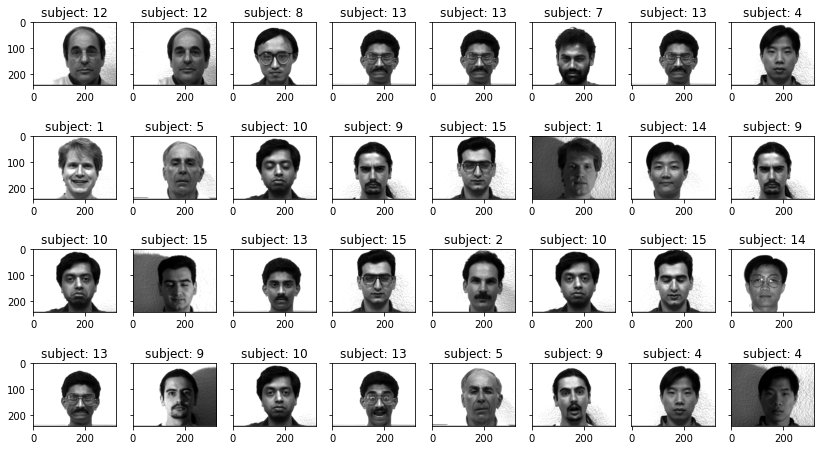

In [34]:
num_faces, num_pixels = X.shape

plt.figure()
f, axes = plt.subplots(4,8, figsize=(14, 8), sharey=True)

for ax in axes:
    for axy in ax:
        face = np.random.randint(0, num_faces)

        axy.imshow(X[face].reshape(yalefaces.SHAPE), cmap='gray')
        axy.set_title(f"subject: {y[face] + 1}")
plt.show()

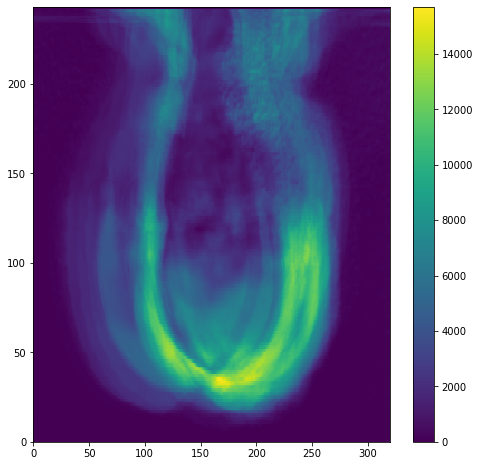

In [36]:
score, p = chi2(X, y)

score_img = (np.array(score)).reshape(yalefaces.SHAPE)
plt.figure(figsize=(8, 8))
colormesh = plt.pcolormesh(a)
plt.colorbar(colormesh)

plt.show()